# Entrenamiento arquitectura recurrente con espectrograma
-----
En este notebook se realiza el entrenamiento de la arquitectura Convolucional sin aplicar normalización, para el desarrollo del trabajo de grado titulado: "Clasificación de patologías cardiovasculares con máquinas de aprendizaje profundo a partir de señales ECG".


# Importando Librerías

In [1]:
import optuna
import plotly
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers, initializers, callbacks
import random as python_random
from numpy.random import seed
np.random.seed(123)
tf.random.set_seed(11)
python_random.seed(123)
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
import json


# Definiendo funciones

In [85]:
TAMANIO=60

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def plot_confusion_matrix(cm, classes,ruta,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2. 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().set_size_inches(6,5)
    plt.savefig(ruta,dpi=300)
    plt.show()
def codificacion(tamano,unico=True,numero=0):
    #Vector de unos
    if unico==True:
        Y_train=np.ones(tamano)*numero
    else:
        for i in range(0,5):
            if i==0:
                Y_train=np.ones(tamano)*i
            else:
                vectorUnos=np.ones(tamano)
                Y_train=np.insert(Y_train,len(Y_train),vectorUnos*i,axis=0)
    return Y_train

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1)
    tf.compat.v1.GPUOptions(visible_device_list = "0")
    set_session(tf.compat.v1.Session(config=config))

def load_data_test_cnn():
    # load your data using this function
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NA\\ECG_'
    ECG_Normal_Test=np.load(path+'Normal\\ECG_Normal_test.npy')
    ECG_SBR_Test=np.load(path+'SBR\\ECG_SBR_Original.npy')
    ECG_SBR_Test=ECG_SBR_Test[300:360,:,:,:]
    ECG_AFIB_Test=np.load(path+'AFIB\\ECG_AFIB_test.npy')
    ECG_STD_Test=np.load(path+'STD\\ECG_STD_test.npy')
    ECG_STE_Test=np.load(path+'STE\\ECG_STE_test.npy')

    filas_seleccionadas = np.random.choice(len(ECG_Normal_Test), size=TAMANIO, replace=False)
    ECG_Normal_Test = ECG_Normal_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_AFIB_Test), size=TAMANIO, replace=False)
    ECG_AFIB_Test = ECG_AFIB_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STD_Test), size=TAMANIO, replace=False)
    ECG_STD_Test = ECG_STD_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STE_Test), size=TAMANIO, replace=False)
    ECG_STE_Test = ECG_STE_Test[filas_seleccionadas]
    

    y_Normal_Test=codificacion(len(ECG_Normal_Test),True,0)
    y_SBR_Test=codificacion(len(ECG_SBR_Test),True,1)
    y_AFIB_Test=codificacion(len(ECG_AFIB_Test),True,2)
    y_STD_Test=codificacion(len(ECG_STD_Test),True,3)
    y_STE_Test=codificacion(len(ECG_STE_Test),True,4)

    #Generando X_train

    X_test=np.concatenate((ECG_Normal_Test,
                                ECG_SBR_Test,
                                ECG_AFIB_Test,
                                ECG_STE_Test,
                                ECG_STD_Test))

    Y_test=np.insert(y_Normal_Test,len(y_Normal_Test),y_SBR_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_AFIB_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STD_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STE_Test,axis=0)    

    print('Tamaño datos test: '+ str(X_test.shape))
    print('Tamaño etiquetas de test: '+str(Y_test.shape))   
    return X_test,Y_test
def load_data_cnn():
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NA\\ECG_'
    #importando patologias
    ECG_Normal_Original=np.load(path+'Normal\\ECG_Normal_Original.npy')
    ECG_SBR_Original=np.load(path+'SBR\\ECG_SBR_Original.npy')
    print(ECG_SBR_Original.shape)
    ECG_AFIB_Original=np.load(path+'AFIB\\ECG_AFIB_Original.npy')
    ECG_STD_Original=np.load(path+'STD\\ECG_STD_Original.npy')
    ECG_STE_Original=np.load(path+'STE\\ECG_STE_Original.npy')
        
    # partiendo base de datos y generando labels
    ECG_Normal_Train=ECG_Normal_Original[:,:,:]
    y_Normal_Train=codificacion(len(ECG_Normal_Train),True,0)
    ECG_SBR_Train=ECG_SBR_Original[:300,:,:]
    y_SBR_Train=codificacion(len(ECG_SBR_Train),True,1)
    ECG_AFIB_Train=ECG_AFIB_Original[:,:,:]
    y_AFIB_Train=codificacion(len(ECG_AFIB_Train),True,2)
    ECG_STD_Train=ECG_STD_Original[:,:,:]
    y_STD_Train=codificacion(len(ECG_STD_Train),True,3)
    ECG_STE_Train=ECG_STE_Original[:,:,:]
    y_STE_Train=codificacion(len(ECG_STE_Train),True,4)

    #Generando Y
    Y_train=np.insert(y_Normal_Train,len(y_Normal_Train),y_SBR_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_AFIB_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STD_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STE_Train,axis=0)


    #Generando X_train

    X_train=np.concatenate((ECG_Normal_Train,
                                ECG_SBR_Train,
                                ECG_AFIB_Train,
                                ECG_STE_Train,
                                ECG_STD_Train))
    print('Tamaño datos entrenamiento: '+ str(X_train.shape))
    print('Tamaño etiquetas de entrenamiento: '+str(Y_train.shape))
    
    X_test,Y_test=load_data_test_cnn()
    
    Y_train= keras.utils.to_categorical(Y_train)
    Y_test= keras.utils.to_categorical(Y_test)
    return X_train,Y_train,X_test,Y_test

In [3]:
# X_train,Y_train,X_test,Y_test=load_data_cnn()
# X_train
# X_test

# print()
# print()
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

# Creando modelo para optimización con Optuna

In [3]:
#Definiendo constantes
EPOCAS=30
ciclo=0
mejores={}
def modelo_CNN(trial):
    # n_hidden=trial.suggest_int('n_hidden',256,1024)
    drop_path_rate = trial.suggest_float("drop_path_rate", 0.5, 0.8, step=0.1)
    # n_hidden=trial.suggest_int('n_hidden',128,1024)
    n_hidden = trial.suggest_categorical("n_hidden", [128,256])
    # Regularización L2
    input_shape = (4000, 51, 241, 2)
    ModelCNN2D=keras.models.Sequential()
    ModelCNN2D.add(keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=input_shape[1:]))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Flatten())
    ModelCNN2D.add(keras.layers.Dense(n_hidden,activation="relu",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelCNN2D.add(keras.layers.Dropout(drop_path_rate))
    ModelCNN2D.add(keras.layers.Dense(5,activation="softmax"))
    ModelCNN2D.summary()
    
    return ModelCNN2D

def create_optimizer_CNN(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    # optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"
    # optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn_CNN(trial,model, optimizer, X,Y,X_test,Y_test):
    global ciclo
    global mejores
    batches=trial.suggest_int('batches',64,256)
    # val_split=trial.suggest_float('val_split',0.1,0.2,step=0.05)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
    Stop = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
    ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\NA\\'
    ruta_modelo_trial=ruta_modelo+'mejor_modelo_trial'+str(ciclo)+'.h5'
    Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
    history_CNN=model.fit(X,Y,verbose=1,validation_data=(X_test,Y_test),epochs=EPOCAS,batch_size=batches,callbacks=[Stop, Checkpoint])
    ciclo+=1
    mejores['trial '+str(ciclo)]=Checkpoint.best
    
    #Guardando historiales
    with open(ruta_modelo+'historial_Modelo_CNN_trial'+str(ciclo)+'.json', 'w') as f:
        json.dump(history_CNN.history, f)
    
    reset_keras()
    gc.collect()
    return history_CNN.history['val_accuracy'][-1]

def objective_CNN(trial):
    ##Datos
    X_train,y_train,X_test,y_test=load_data_cnn()
    
    # Clear clutter from previous session graphs.
    # keras.backend.clear_session()
    #Contruyendo modelo y optimizador
    model=modelo_CNN(trial)
    optimizer=create_optimizer_CNN(trial)
    
    #Entrenando y validando
    loss=learn_CNN(trial,model,optimizer,X_train,y_train,X_test,y_test)
    # reset_keras()
    return loss

In [4]:
study_CNN=optuna.create_study(direction="maximize") #Para minimizar la función de pérdida

[I 2023-04-09 22:59:42,204] A new study created in memory with name: no-name-b9c0969f-38fe-41b2-91e7-710e4e52c600


In [5]:
study_CNN.optimize(objective_CNN,n_trials=50)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:03:52,040] Trial 0 finished with value: 0.40666666626930237 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 7.773820689183855e-05, 'batches': 166}. Best is trial 0 with value: 0.40666666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:07:32,414] Trial 1 finished with value: 0.6666666865348816 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 256, 'adam_learning_rate': 0.0013627126641957647, 'batches': 215}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:11:40,459] Trial 2 finished with value: 0.6499999761581421 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.00013594034990803704, 'batches': 119}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:15:27,441] Trial 3 finished with value: 0.3733333349227905 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 6.275841955856475e-05, 'batches': 213}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:17:04,480] Trial 4 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.00989157527142591, 'batches': 104}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:21:01,025] Trial 5 finished with value: 0.6266666650772095 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.00018207324088823022, 'batches': 123}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:24:50,578] Trial 6 finished with value: 0.36000001430511475 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 7.596617631203336e-05, 'batches': 183}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:28:46,430] Trial 7 finished with value: 0.3799999952316284 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 3.722223578450669e-05, 'batches': 96}. Best is trial 1 with value: 0.6666666865348816.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:32:46,462] Trial 8 finished with value: 0.79666668176651 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0015762389816845483, 'batches': 80}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:34:14,121] Trial 9 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.07435073204484204, 'batches': 231}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:38:22,615] Trial 10 finished with value: 0.7766666412353516 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.001362495210822922, 'batches': 66}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:42:26,048] Trial 11 finished with value: 0.75 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0013717371537917374, 'batches': 66}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:46:24,717] Trial 12 finished with value: 0.6666666865348816 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0005996115046787046, 'batches': 73}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:47:56,976] Trial 13 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 1.5199036189092616e-05, 'batches': 142}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:51:46,632] Trial 14 finished with value: 0.653333306312561 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0043854388474062565, 'batches': 80}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:55:44,185] Trial 15 finished with value: 0.6100000143051147 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0003740310909648367, 'batches': 90}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 23:59:07,247] Trial 16 finished with value: 0.6800000071525574 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0032787482483181735, 'batches': 256}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:02:51,759] Trial 17 finished with value: 0.5833333134651184 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.00040621536675307976, 'batches': 133}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:04:35,151] Trial 18 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.01297621079185931, 'batches': 64}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:08:21,520] Trial 19 finished with value: 0.6466666460037231 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0010780520164006193, 'batches': 105}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:12:01,198] Trial 20 finished with value: 0.6966666579246521 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.001995587403033312, 'batches': 159}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:16:08,101] Trial 21 finished with value: 0.6433333158493042 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0008137325273216557, 'batches': 66}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:20:01,069] Trial 22 finished with value: 0.7166666388511658 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.002248364653255787, 'batches': 87}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:23:51,013] Trial 23 finished with value: 0.6366666555404663 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0002578183812197245, 'batches': 111}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:27:46,838] Trial 24 finished with value: 0.6833333373069763 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0007288716222423245, 'batches': 82}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:31:43,467] Trial 25 finished with value: 0.699999988079071 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0011269382252491393, 'batches': 64}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:35:43,555] Trial 26 finished with value: 0.5133333206176758 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.005605953393400499, 'batches': 97}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:39:44,162] Trial 27 finished with value: 0.6833333373069763 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0004214304570238147, 'batches': 77}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:43:25,215] Trial 28 finished with value: 0.6899999976158142 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0018917382202730064, 'batches': 140}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:47:13,507] Trial 29 finished with value: 0.5799999833106995 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.0001799899862761472, 'batches': 185}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:50:54,773] Trial 30 finished with value: 0.5766666531562805 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0006717668613265519, 'batches': 151}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:54:44,710] Trial 31 finished with value: 0.6899999976158142 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0022715282632068657, 'batches': 87}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 00:58:35,074] Trial 32 finished with value: 0.6000000238418579 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0014469504890458188, 'batches': 89}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:02:15,124] Trial 33 finished with value: 0.7099999785423279 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.003139237167746337, 'batches': 122}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:06:26,126] Trial 34 finished with value: 0.6333333253860474 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0012110846243808347, 'batches': 75}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:07:57,450] Trial 35 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.005830660319098481, 'batches': 105}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:11:53,811] Trial 36 finished with value: 0.6899999976158142 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.001595942718257373, 'batches': 116}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:13:24,790] Trial 37 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.008778815622934616, 'batches': 96}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:17:22,242] Trial 38 finished with value: 0.6700000166893005 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0025854436588972395, 'batches': 74}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:20:59,040] Trial 39 finished with value: 0.38333332538604736 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0001326123115911758, 'batches': 187}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:24:52,651] Trial 40 finished with value: 0.6433333158493042 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.0008734089499087774, 'batches': 128}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:28:36,155] Trial 41 finished with value: 0.6499999761581421 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.003785914862760862, 'batches': 117}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:32:24,616] Trial 42 finished with value: 0.6966666579246521 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.002936555148507354, 'batches': 86}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:36:23,471] Trial 43 finished with value: 0.7099999785423279 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0019518099023552035, 'batches': 71}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:40:14,738] Trial 44 finished with value: 0.6399999856948853 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0032335004311538035, 'batches': 100}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:44:14,320] Trial 45 finished with value: 0.70333331823349 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.00048510503947268586, 'batches': 81}. Best is trial 8 with value: 0.79666668176651.


3692
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 fl

[I 2023-04-10 01:48:07,603] Trial 46 finished with value: 0.7400000095367432 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.001159928542916026, 'batches': 92}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:52:00,227] Trial 47 finished with value: 0.6833333373069763 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0012804939086630853, 'batches': 92}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:56:02,978] Trial 48 finished with value: 0.6333333253860474 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0006513970994847591, 'batches': 71}. Best is trial 8 with value: 0.79666668176651.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-10 01:59:31,354] Trial 49 finished with value: 0.5733333230018616 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.000999969807384771, 'batches': 207}. Best is trial 8 with value: 0.79666668176651.


# Graficas obetenidas de la optimización

In [6]:
# import plotly.io as pio
fig = optuna.visualization.plot_param_importances(study_CNN)
# pio.write_image(fig, 'nombre_del_archivo.png')
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Importancia de los hiperparámetros en la optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [7]:
fig = optuna.visualization.plot_contour(study_CNN, params=["adam_learning_rate", "batches"],target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Gráfico de líneas de contorno",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [8]:
fig = optuna.visualization.plot_optimization_history(study_CNN,target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text': "Gráfico de historial de optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show( config=config)

In [ ]:
#Ubicacion del mejor modelo entrenado
max_key = None
max_value = float('-inf')

for key, value in mejores.items():
    if value > max_value:
        max_key = key
        max_value = value

print(f"La clave con el valor más alto es '{max_key}' con valor {max_value}\n")

#Extrayendo hiperparametros del mejor trial
print("Number of finished trials: ", len(study_CNN.trials))
print("Number of BEST trials: ", study_CNN.best_trial.number)
print("Best trial:")
trial = study_CNN.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

La clave con el valor más alto es 'trial 11' con valor 0.8033333420753479

Number of finished trials:  50
Number of BEST trials:  8
Best trial:
  Value:  0.79666668176651
  Params: 
    drop_path_rate: 0.7
    n_hidden: 128
    adam_learning_rate: 0.0015762389816845483
    batches: 80


# Mejor modelo Optuna por checkpoint

Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)

10/10 [==============================] - 0s 9ms/step
[[1.00000000e+00 2.34274267e-11 3.44016038e-10 2.34269706e-08
  4.47130083e-10]
 [3.31315577e-01 1.95075609e-02 2.36258041e-02 3.94540131e-01
  2.31010959e-01]
 [9.99917269e-01 2.48458978e-08 1.19614796e-07 6.63825122e-05
  1.62120432e-05]
 ...
 [3.28970924e-02 6.45243929e-08 8.82869742e-08 2.95391019e-05
  9.67073262e-01]
 [9.99978065e-01 2.42786854e-07 7.99392069e-07 1.97473764e-05
  1.20442996e-06]
 [1.62388416e-04 5.34347950e-25 5.44460827e-26 1.03630286e-19
  9.99837637e-01]]
Normalized confusion matrix
[[0.62 0.   0.17 0.2  0.02]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.22 0.   0.   0.67 0.12]
 [0.25 0.   0.   0.18 0.57]]


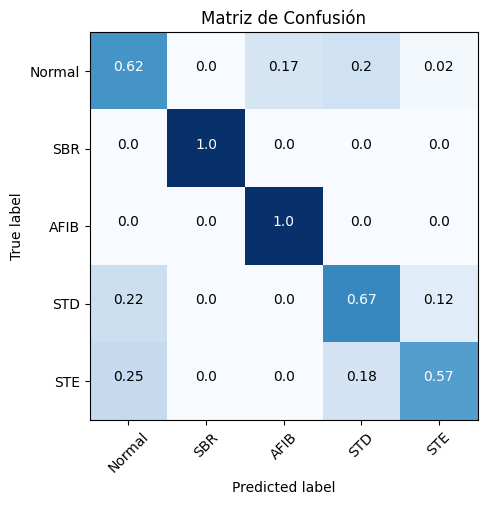

In [88]:

# cargar datos de prueba
data_test, labels_test = load_data_test_cnn()

# Imprimiendo tamaño de test
print()

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\NA\\mejor_modelo_trial'
modelo='10'
Best_Model_CNN = keras.models.load_model(model_file+modelo+'.h5',custom_objects={'f1': f1})
# hacer la predicción
y_prediction = Best_Model_CNN.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\NA\\'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, ruta=ruta+'MatrizMejorModeloOptuna_NA.png',title='Matriz de Confusión',normalize=True)

# Entrenando modelo con los mejores Hiperparámetros

In [4]:
def create_model_cnn():
    input_shape = (4000, 51, 241, 2)
    ModelCNN2D=keras.models.Sequential()
    ModelCNN2D.add(keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=input_shape[1:]))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Flatten())
    ModelCNN2D.add(keras.layers.Dense(256,activation="relu",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelCNN2D.add(keras.layers.Dropout(0.6))
    ModelCNN2D.add(keras.layers.Dense(5,activation="softmax"))
    ModelCNN2D.summary()
    return ModelCNN2D


In [5]:
K.clear_session()
reset_keras()
data_test, labels_test_OHE,data_val, labels_val_OHE = load_data_cnn()
# Entrenando y guardando el modelo
Best_Hiper_ModelCNN=create_model_cnn()
opt = optimizers.Adam(learning_rate=0.000557766173243489)
Best_Hiper_ModelCNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsMejoresHiperparametros\\NA\\'
ruta_modelo_trial=ruta_modelo+'mejor_modelo_CNN_NA.h5'
Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
history=Best_Hiper_ModelCNN.fit(data_test,labels_test_OHE,verbose=1,epochs=50,batch_size=182,validation_data=(data_val,labels_val_OHE),callbacks=[Checkpoint])

137
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 fla

# Graficas modelo con los mejores hiperparámetros

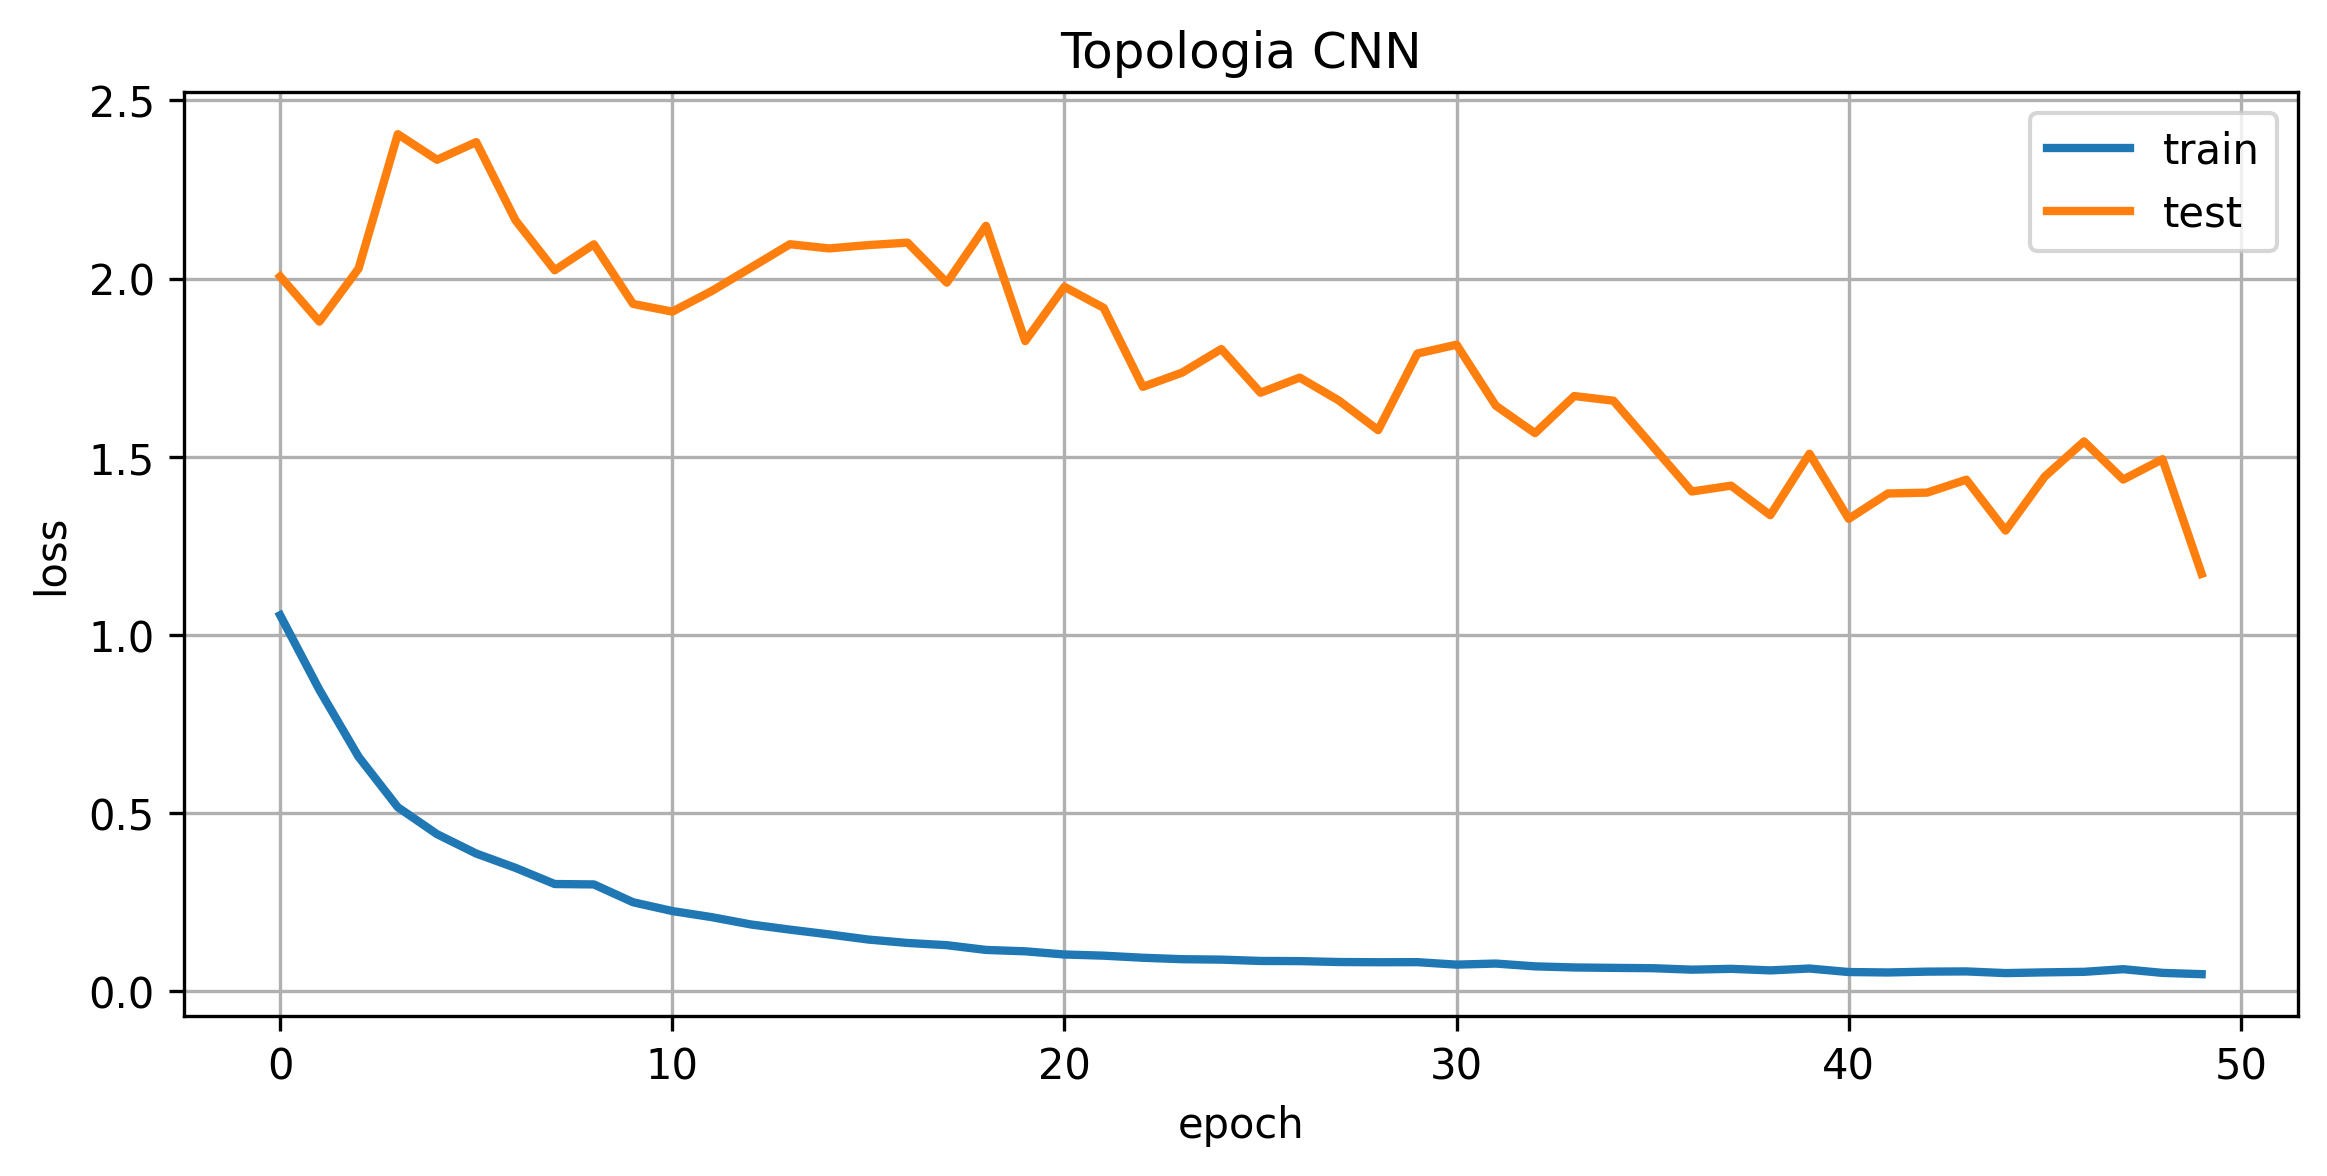

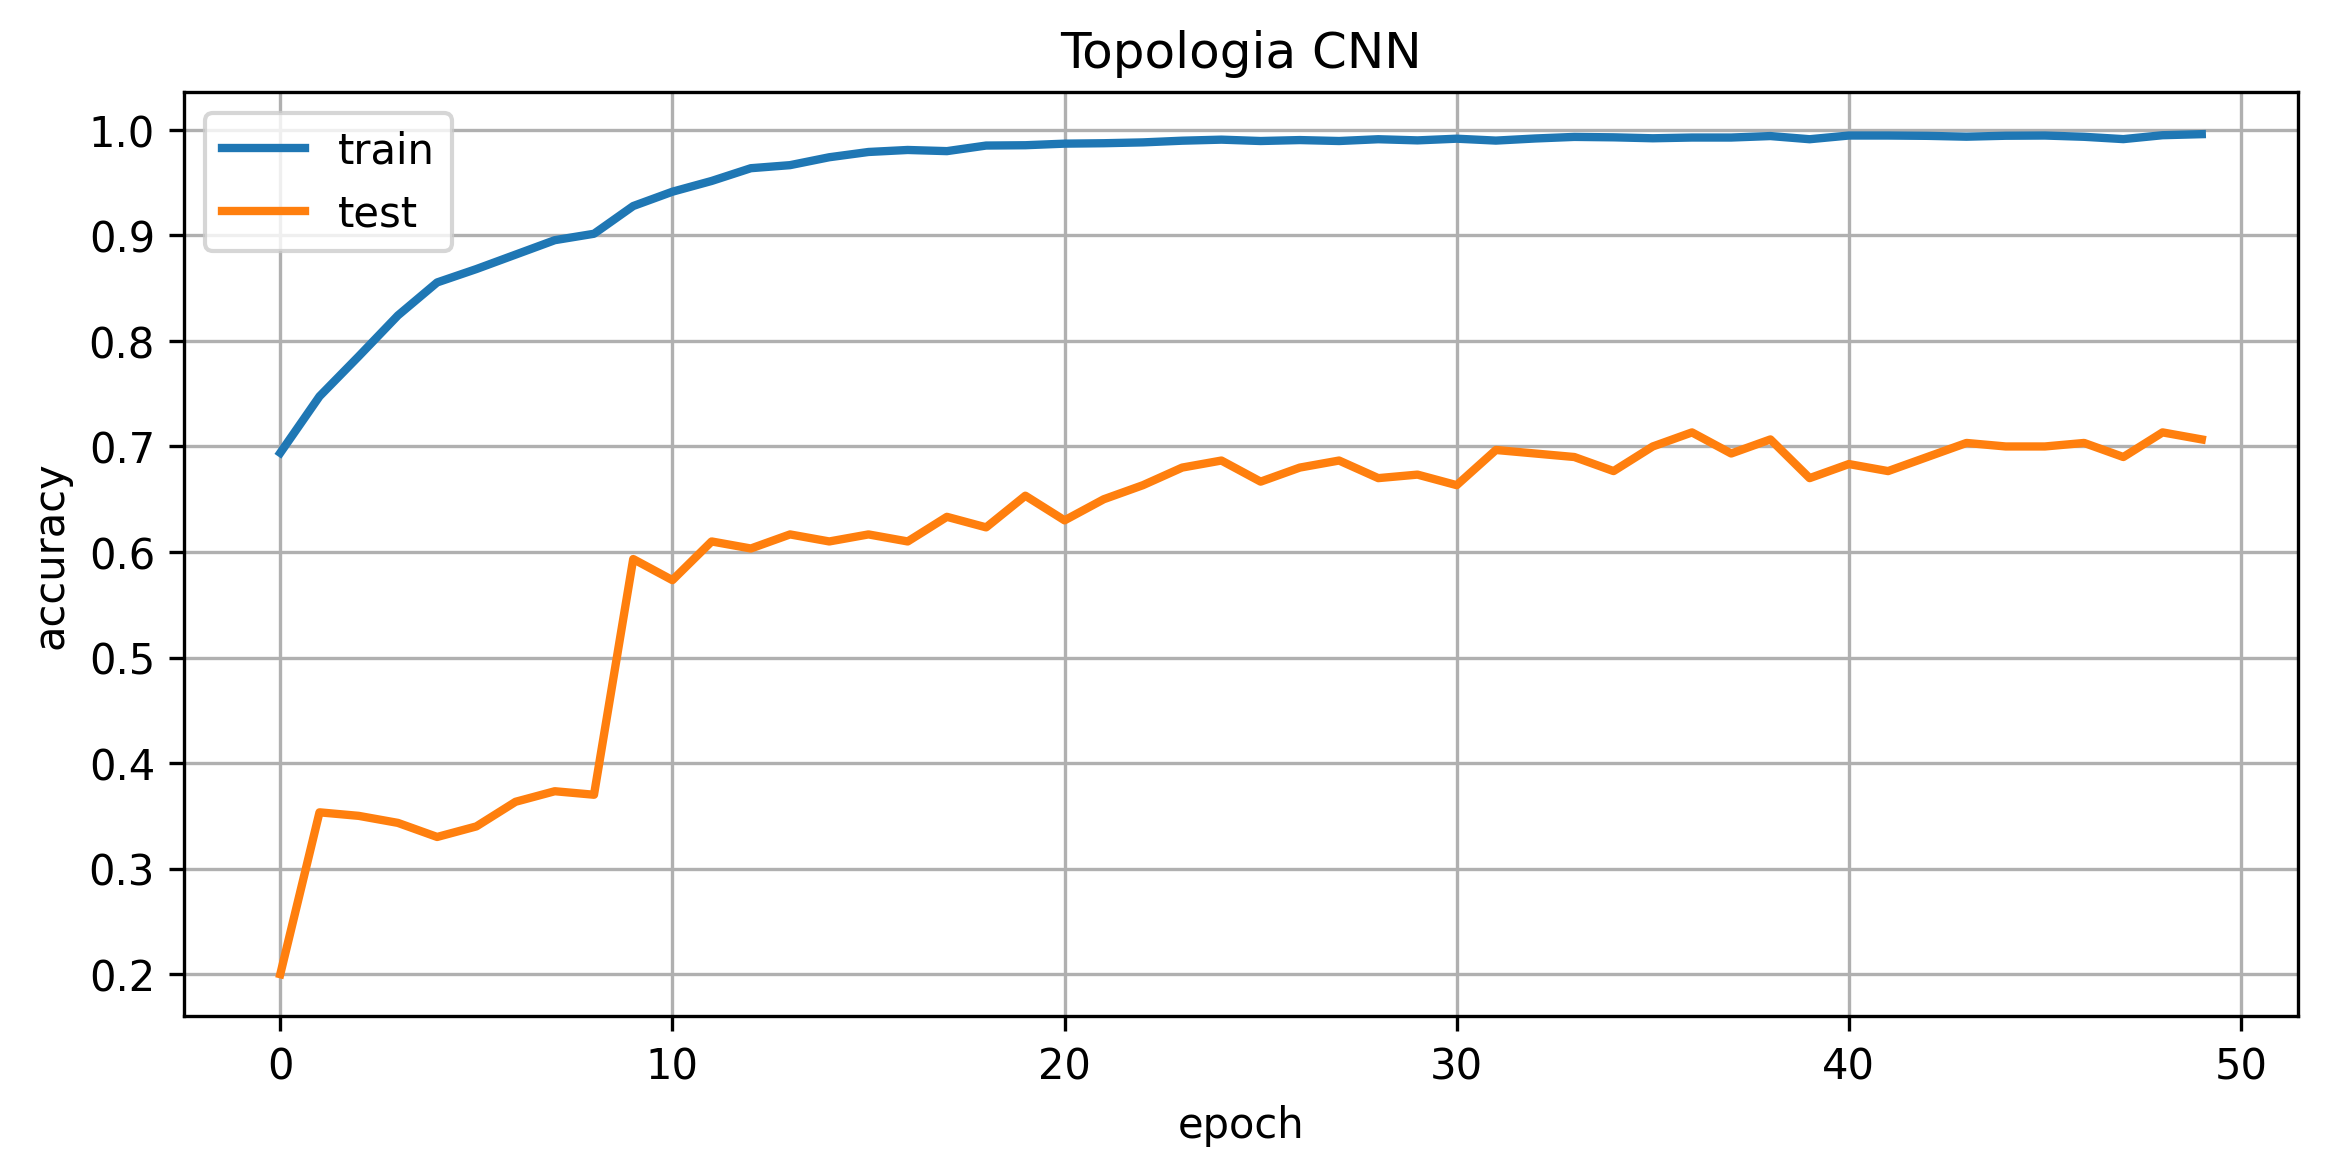

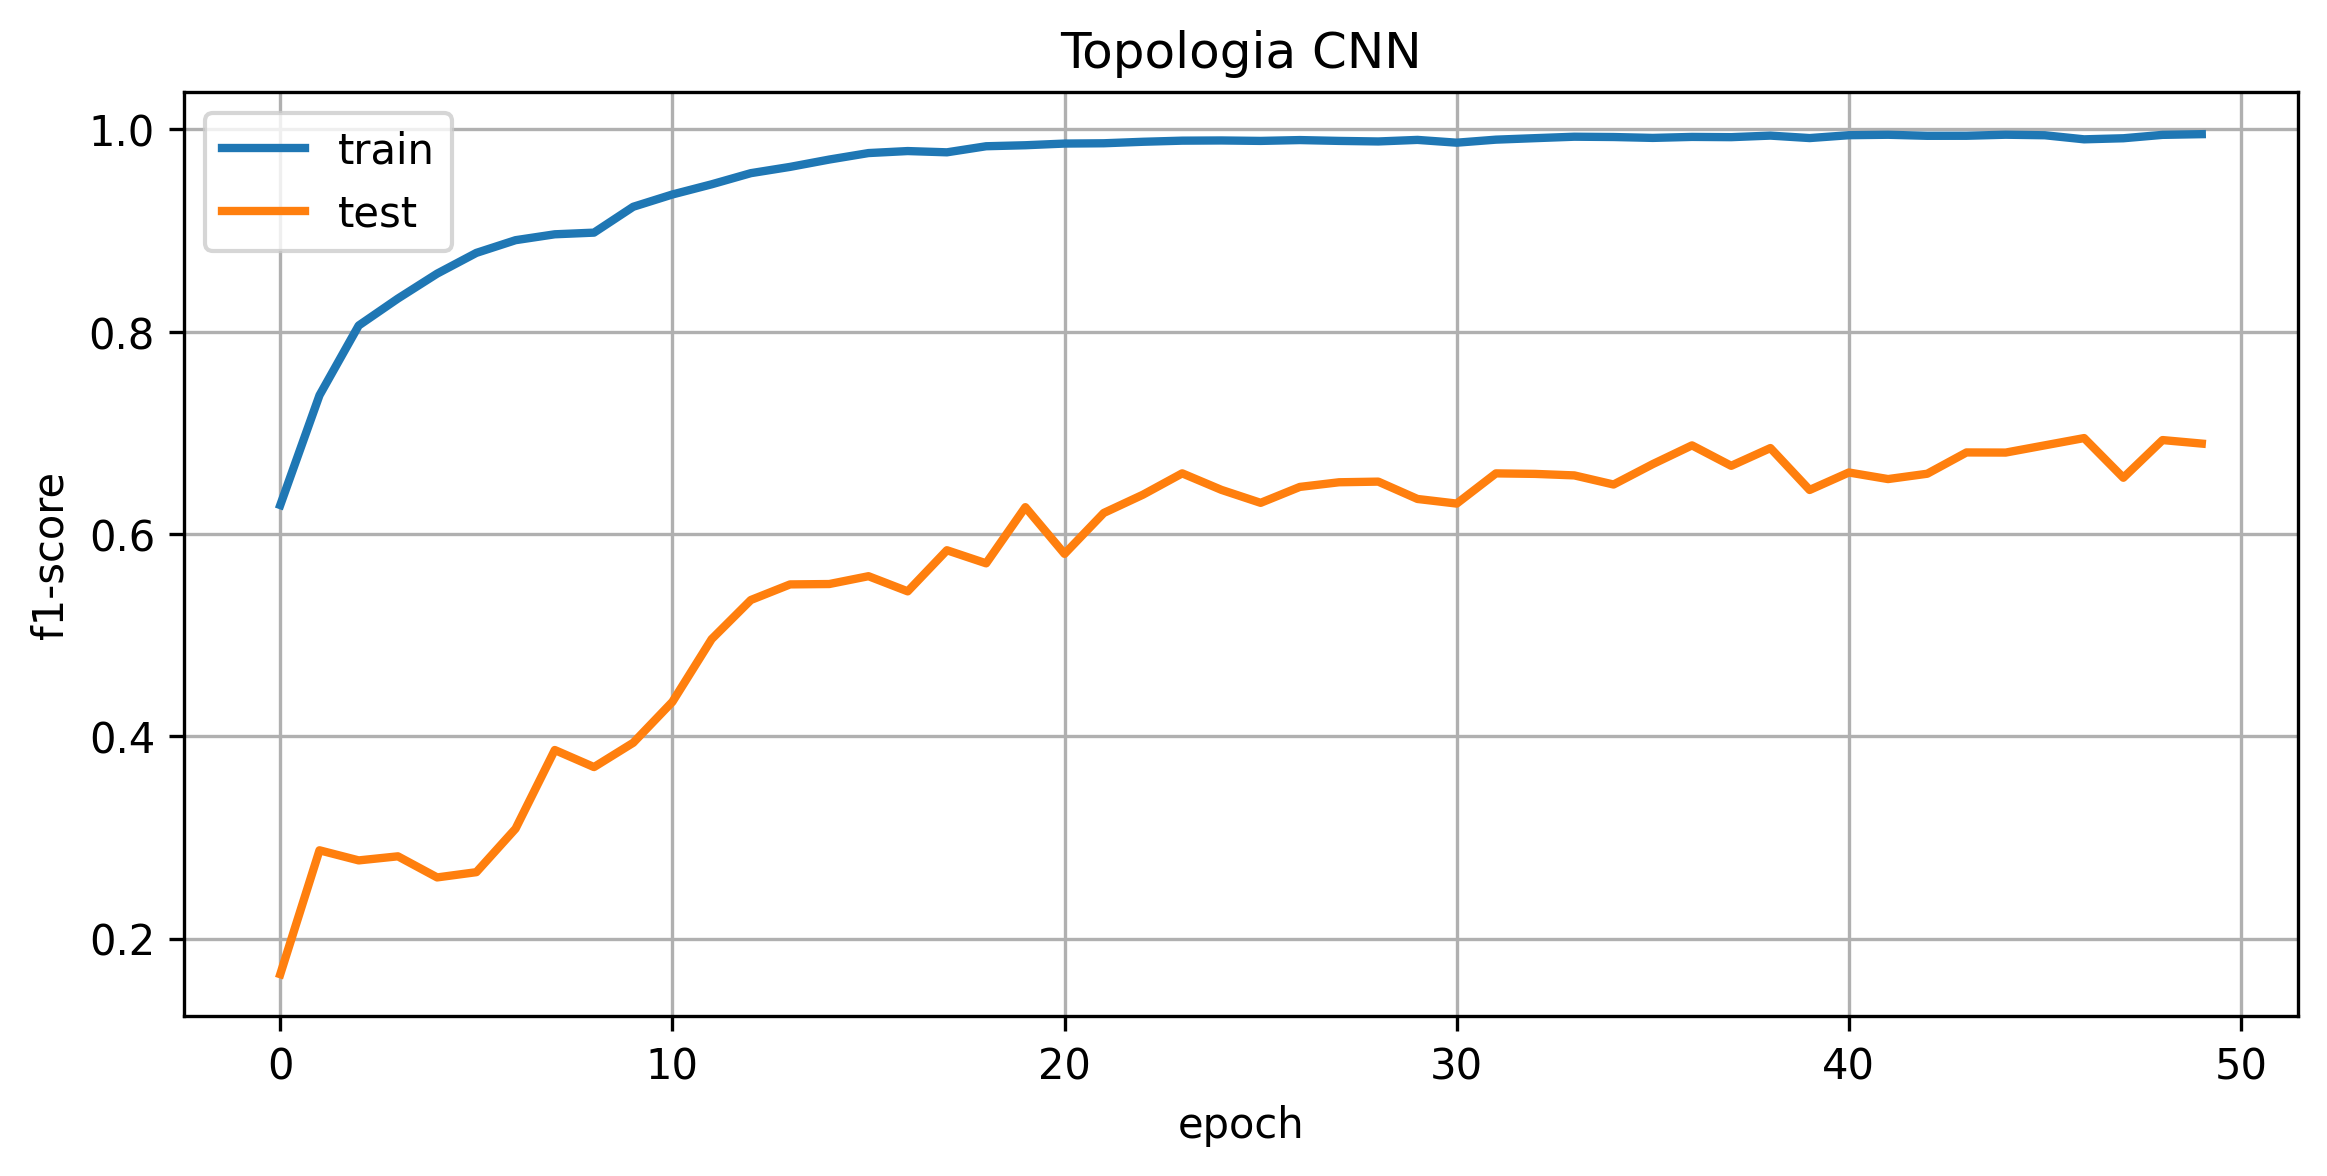

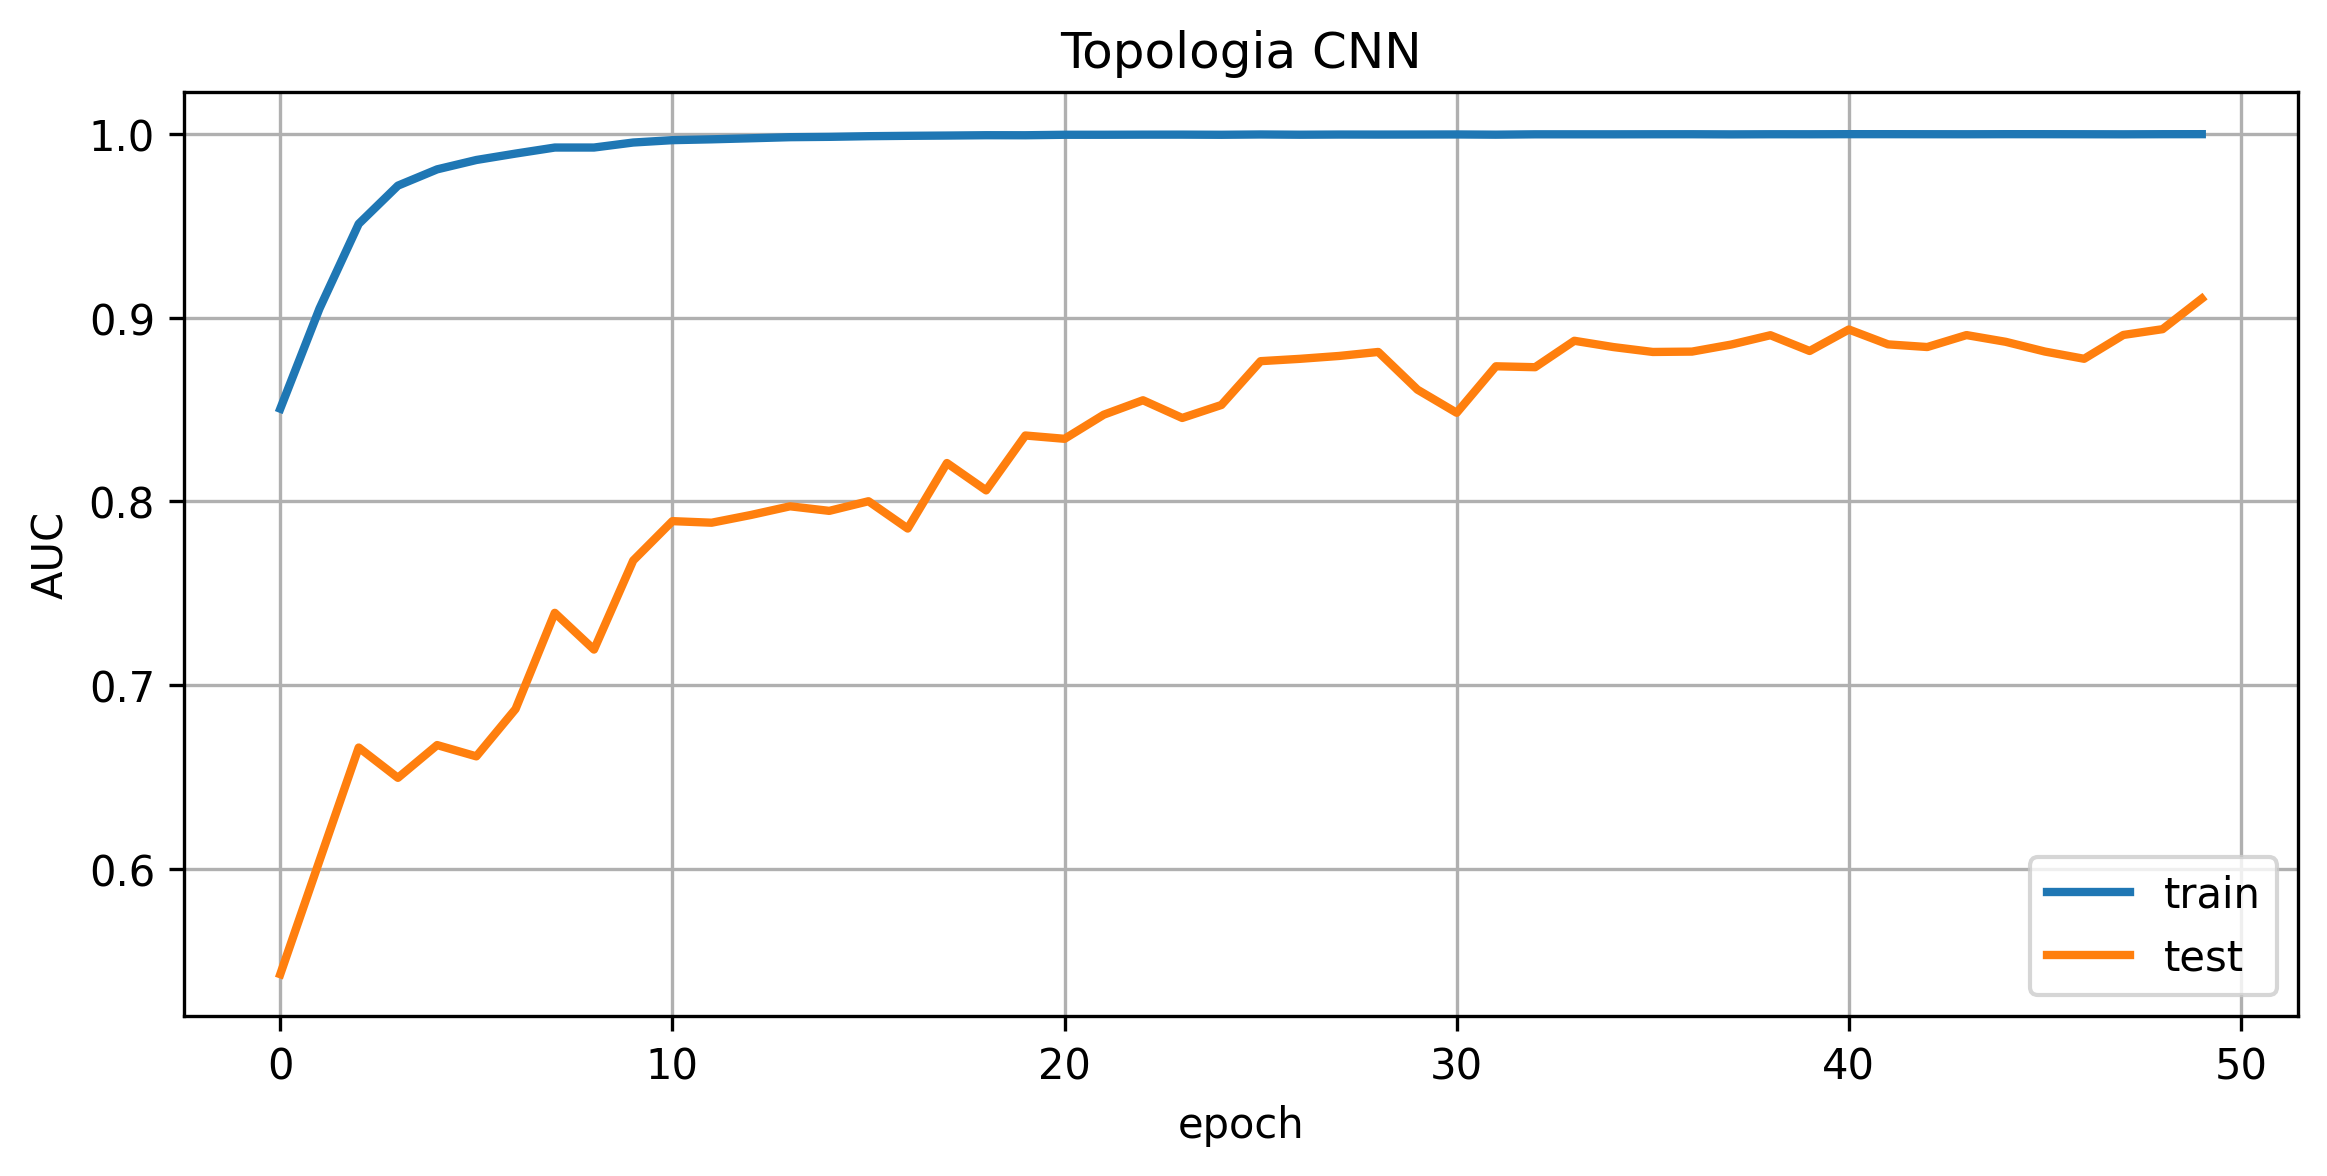

In [6]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linewidth=2, )
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Topologia CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linewidth=2,)
plt.plot(history.history['val_accuracy'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['auc'], linewidth=2,)
plt.plot(history.history['val_auc'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()


Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 20ms/step
[[5.79636602e-04 1.19788114e-04 9.83523309e-01 3.82231595e-03
  1.19549613e-02]
 [1.35184685e-03 9.81388512e-05 2.69285776e-02 4.95282710e-01
  4.76338714e-01]
 [6.01581216e-01 1.21344507e-04 3.00926017e-03 3.78219217e-01
  1.70689691e-02]
 ...
 [7.67750144e-02 4.50914074e-03 2.52478849e-02 7.33862877e-01
  1.59605160e-01]
 [1.03439547e-01 4.40261420e-03 2.45714933e-02 6.46208107e-01
  2.21378297e-01]
 [6.52941208e-06 3.91791599e-11 3.46044193e-09 2.38416752e-11
  9.99993443e-01]]
Normalized confusion matrix
[[0.38 0.   0.12 0.33 0.17]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.03]
 [0.32 0.   0.   0.45 0.23]
 [0.07 0.   0.   0.27 0.67]]


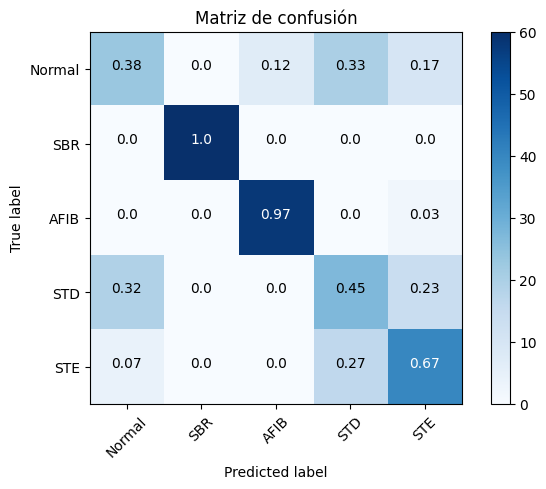

In [7]:
data_test, labels_test = load_data_test_cnn()
y_prediction = Best_Hiper_ModelCNN.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\NA\\MatrizDatosTestModeloEntrenadoNA.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta, title='Matriz de confusión',normalize=True)

# Mejor modelo entrenado del modelo de hiperparámetros

Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 0s 31ms/step
[[1.53877497e-01 6.92878966e-04 6.45185960e-03 7.43370891e-01
  9.56068635e-02]
 [1.82242915e-02 2.41846498e-03 3.13684568e-02 6.73108041e-01
  2.74880826e-01]
 [8.21475126e-03 3.94166651e-04 2.64467523e-02 6.59669816e-01
  3.05274576e-01]
 ...
 [5.06266719e-03 2.43866975e-06 4.95182485e-06 1.04554174e-05
  9.94919479e-01]
 [9.70359087e-01 1.92088759e-04 2.54097482e-04 1.78694502e-02
  1.13252215e-02]
 [2.95066275e-04 3.88378718e-10 4.01750500e-09 3.03075426e-10
  9.99704897e-01]]
Normalized confusion matrix
[[0.42 0.   0.15 0.37 0.07]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.37 0.   0.   0.52 0.12]
 [0.2  0.   0.   0.15 0.65]]


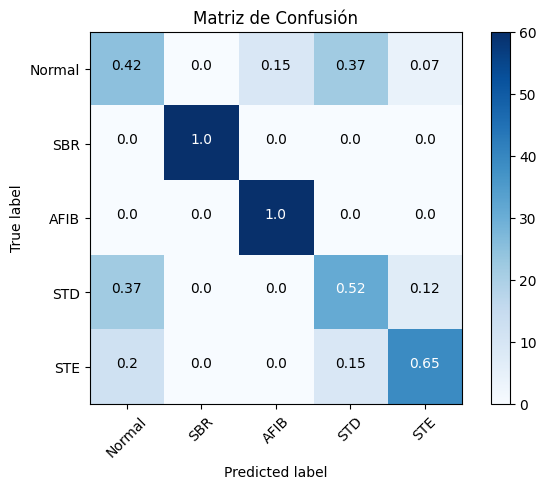

In [8]:
# cargar datos de prueba
data_test, labels_test = load_data_test_cnn()
# data_test=np.moveaxis(data_test,1,-2)

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsMejoresHiperparametros\\NA\\'
ModelCNN_best = keras.models.load_model(model_file+'mejor_modelo_CNN_NA.h5',custom_objects={"f1": f1})
# hacer la predicción
y_prediction = ModelCNN_best.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\NA\\MatrizDatosTestMejorModeloEntrenadoNA.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta,title='Matriz de Confusión',normalize=True)

# Guardando datos del modelo entrenado

In [58]:
import json
#Guardando historiales
path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\NA\\'
with open(path+'historial_Modelo_CNN_NA_final.json', 'w') as f:
    json.dump(history.history, f)

#Guardando mejor modelo
Best_Hiper_ModelCNN.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\NA\\Modelo_CNN_NA_final.h5')
ModelCNN_best.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\NA\\Modelo_CNN_NA_Best_final.h5')

In [1]:
import json
ruta_json='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\NA\\historial_Modelo_CNN_trial'
archivoAcargar='11.json'
with open(ruta_json+archivoAcargar, 'r') as archivo_json:
    datos = json.load(archivo_json)

print(datos)

{'loss': [0.9115978479385376, 0.5734038352966309, 0.4155319333076477, 0.34127599000930786, 0.29861176013946533, 0.24748046696186066, 0.20930027961730957, 0.17712093889713287, 0.16166412830352783, 0.15391181409358978, 0.15874025225639343, 0.14497500658035278, 0.12992249429225922, 0.129183828830719, 0.11486735939979553, 0.10307875275611877, 0.106659434735775, 0.10250847041606903, 0.11309988051652908, 0.09799231588840485, 0.09807360917329788, 0.08900482207536697, 0.08551128953695297, 0.08995282649993896, 0.08152520656585693, 0.07818558812141418, 0.08302679657936096, 0.08424955606460571, 0.08086464554071426, 0.07612849026918411], 'accuracy': [0.7273090481758118, 0.8042935729026794, 0.8546180725097656, 0.8732900619506836, 0.8997503519058228, 0.9258112907409668, 0.9433849453926086, 0.9541687369346619, 0.9617573618888855, 0.9621567726135254, 0.958961546421051, 0.9631552696228027, 0.9655516743659973, 0.9659510850906372, 0.9723414778709412, 0.9772341251373291, 0.9751372933387756, 0.974937617778

In [2]:
import numpy as np
index_max=np.argmax(datos['val_accuracy'])
print('val_accuracy:',datos['val_accuracy'][index_max]*100)

index_max=np.argmax(datos['accuracy'])
print('accuracy:',datos['accuracy'][index_max]*100)

index_max=np.argmax(datos['val_f1'])
print('val_f1:',datos['val_f1'][index_max]*100)

index_max=np.argmax(datos['f1'])
print('f1:',datos['f1'][index_max]*100)

index_max=np.argmax(datos['val_auc'])
print('val_auc:',datos['val_auc'][index_max]*100)

index_max=np.argmax(datos['auc'])
print('auc:',datos['auc'][index_max]*100)

val_accuracy: 80.33333420753479
accuracy: 98.26260805130005
val_f1: 79.54298257827759
f1: 98.29268455505371
val_auc: 92.3056960105896
auc: 99.96116757392883


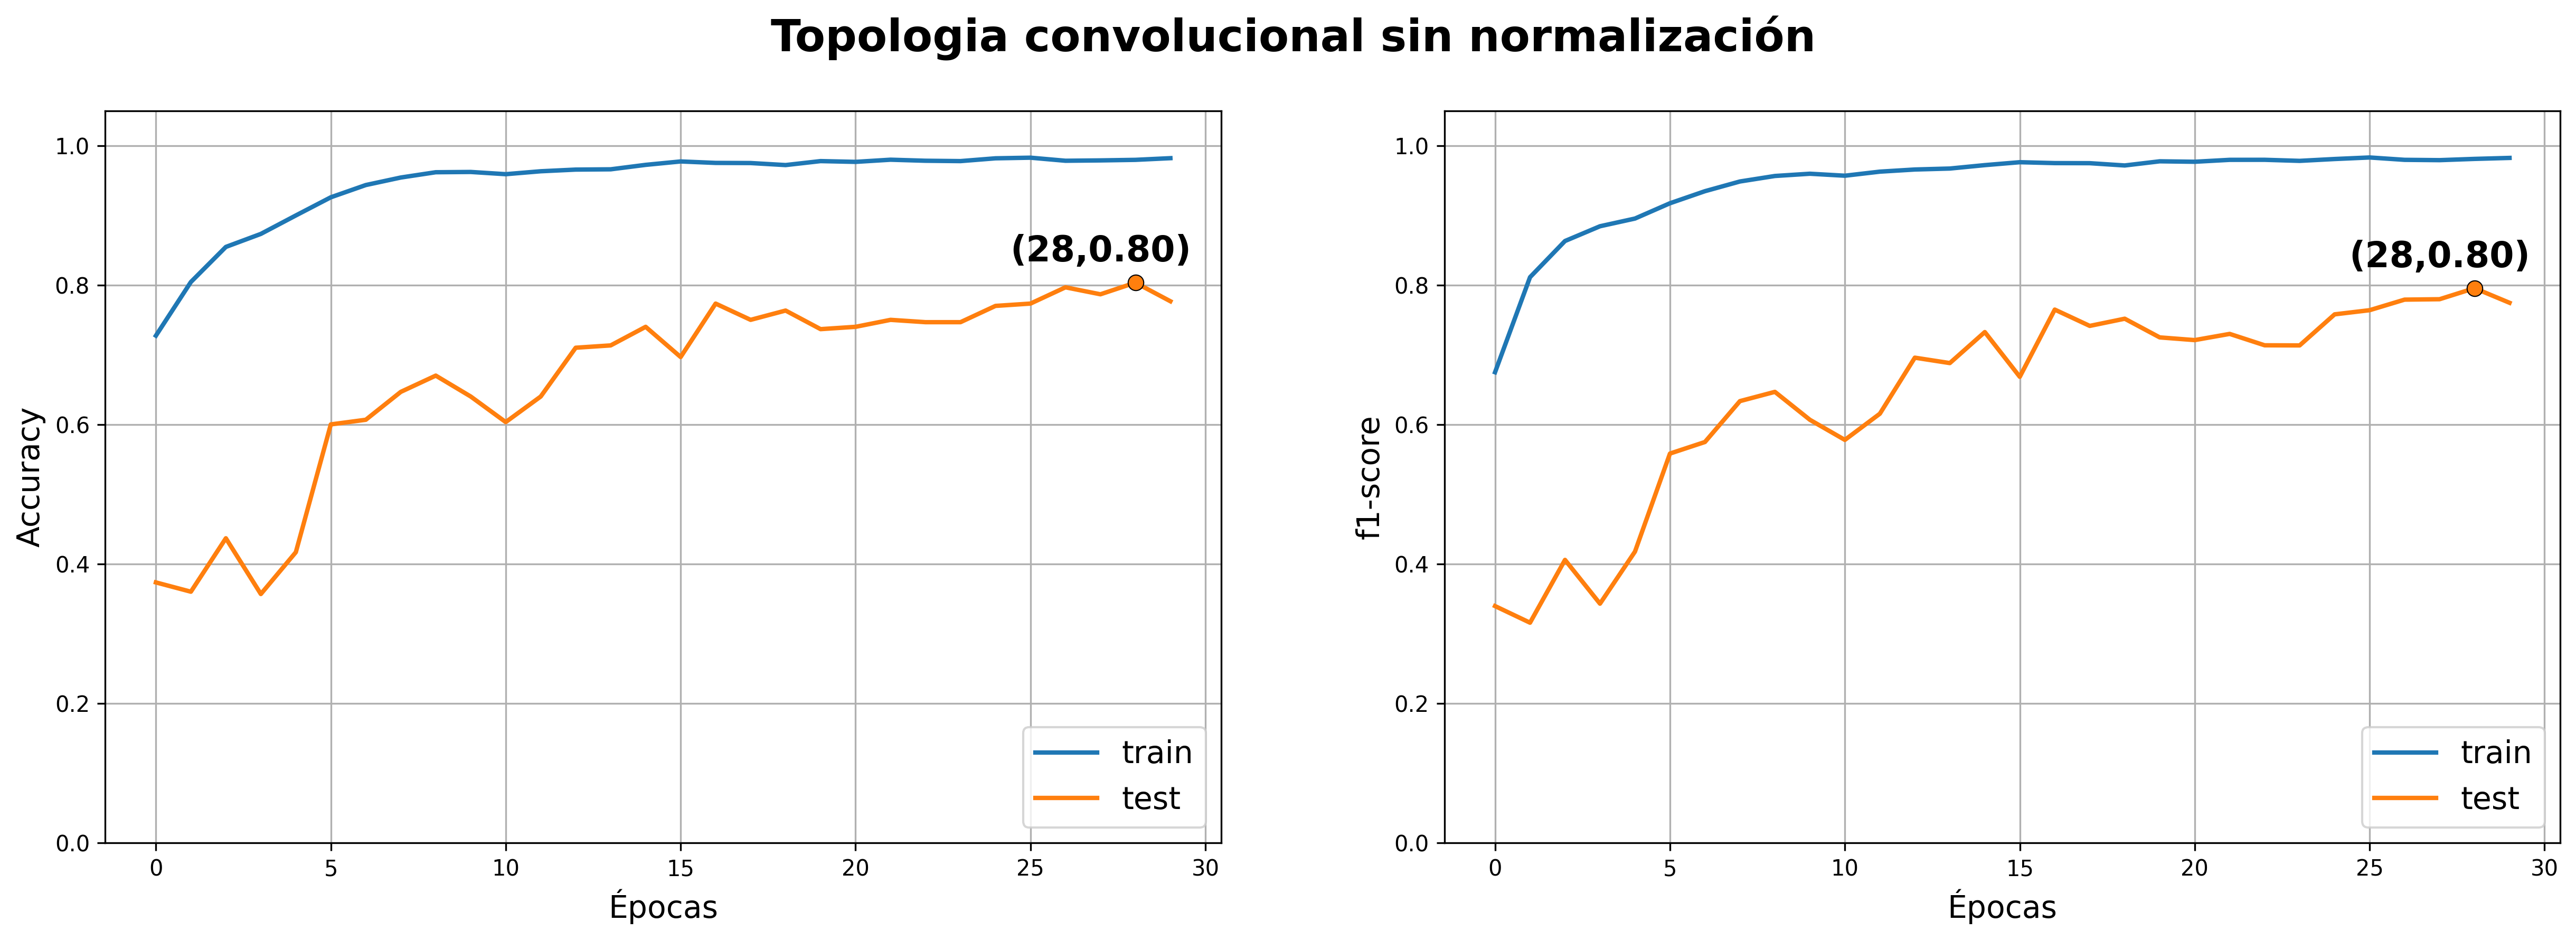

In [49]:
# Datos de ejemplo

# Configuración de la figura
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi=300)

# Gráfica 1 - Accuracy
axs[0].plot(datos['accuracy'], linewidth=2,)
axs[0].plot(datos['val_accuracy'], linewidth=2,)
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].set_xlabel('Épocas',fontsize=14)
axs[0].legend(['train', 'test'],loc='lower right',fontsize=14)
axs[0].grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
axs[0].scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
axs[0].text(t_max-1, y_max+0.02,f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold',fontsize=16)

# Gráfica 2 - F1-score
axs[1].plot(datos['f1'], linewidth=2,)
axs[1].plot(datos['val_f1'], linewidth=2,)
axs[1].set_ylabel('f1-score',fontsize=14)
axs[1].set_xlabel('Épocas',fontsize=14)
axs[1].legend(['train', 'test'],loc='lower right',fontsize=14)
axs[1].grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
axs[1].scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
axs[1].text(t_max-1, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold',fontsize=16)

# # Gráfica 3 - AUC
# axs[2].plot(datos['auc'], linewidth=2,)
# axs[2].plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
# axs[2].set_ylabel('AUC')
# axs[2].set_xlabel('Épocas')
# axs[2].legend(['train', 'test'],loc='lower right')
# axs[2].grid()

# Encontrar el índice y el valor máximo
# index_max = np.argmax(datos['val_auc'])
# y_max = datos['val_auc'][index_max]
# t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
# axs[2].scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
# axs[2].text(t_max-1, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el mismo rango máximo en los tres ejes Y
y_max = 1.05
axs[0].set_ylim([0, y_max])
axs[1].set_ylim([0, y_max])
# axs[2].set_ylim([0, y_max])

fig.suptitle('Topologia convolucional sin normalización',fontweight='bold', fontsize=20)

# Mostrar la figura
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NA\\HistorialEntrenamiento.png', dpi=300)
plt.show()

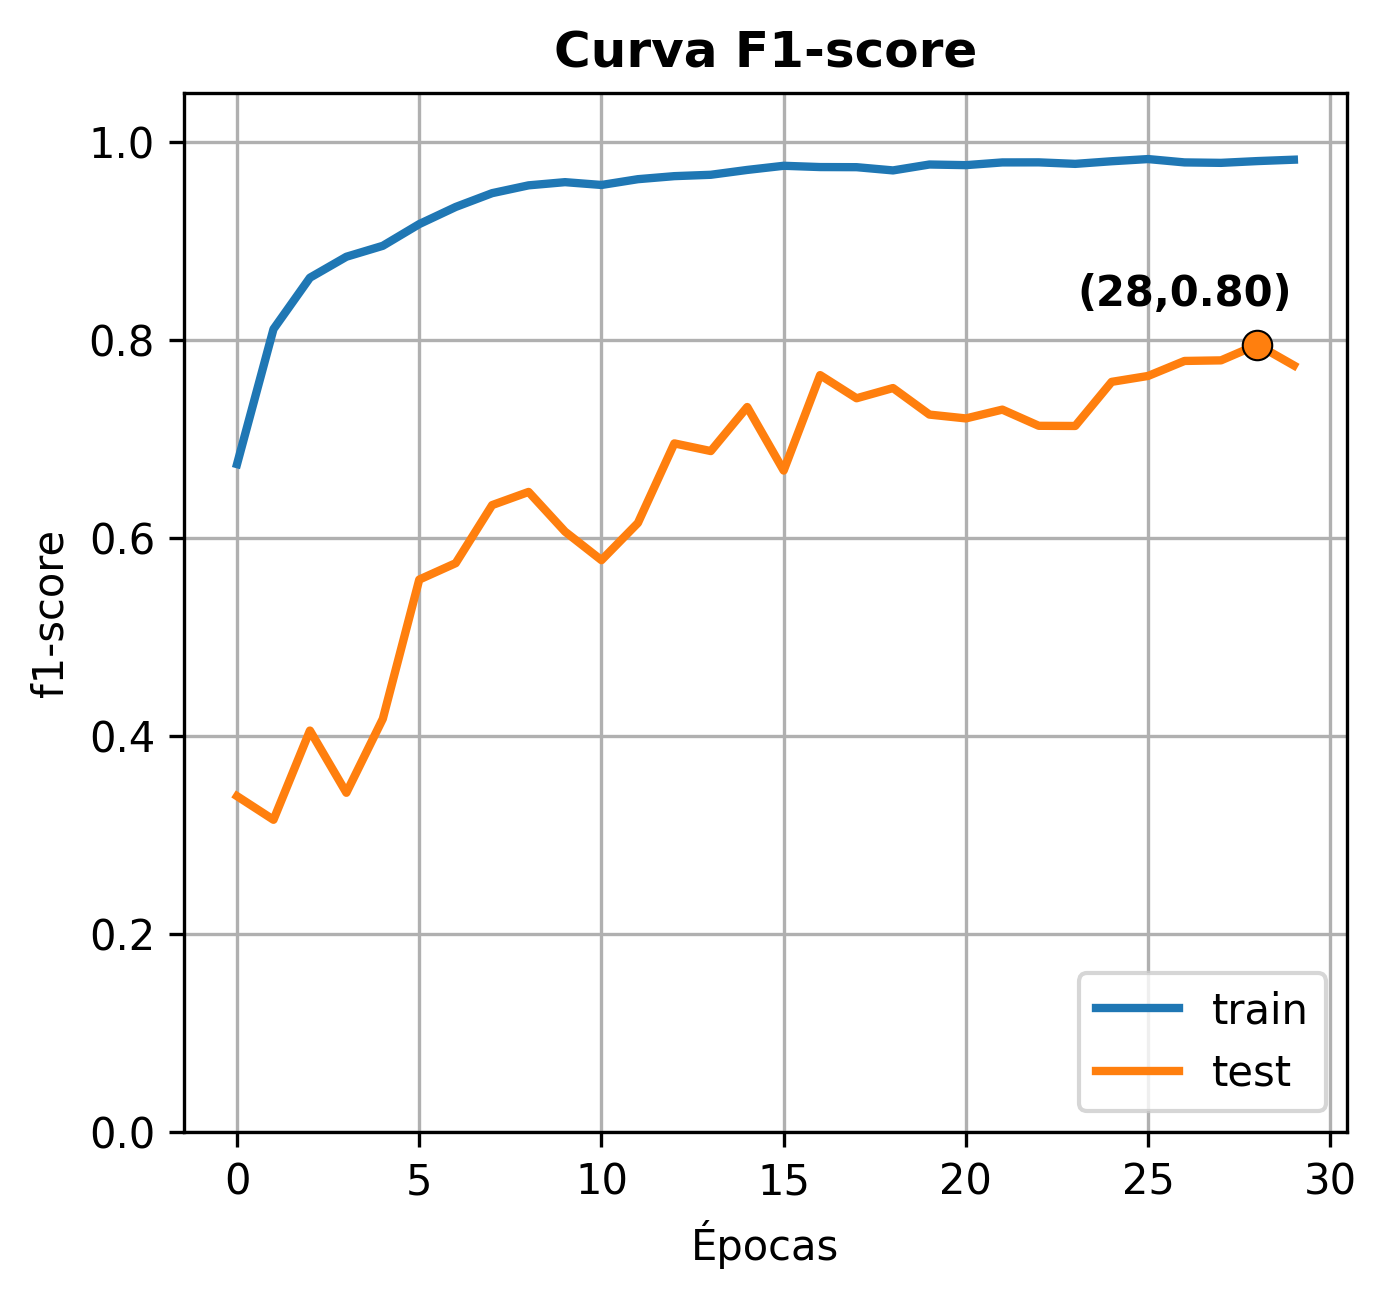

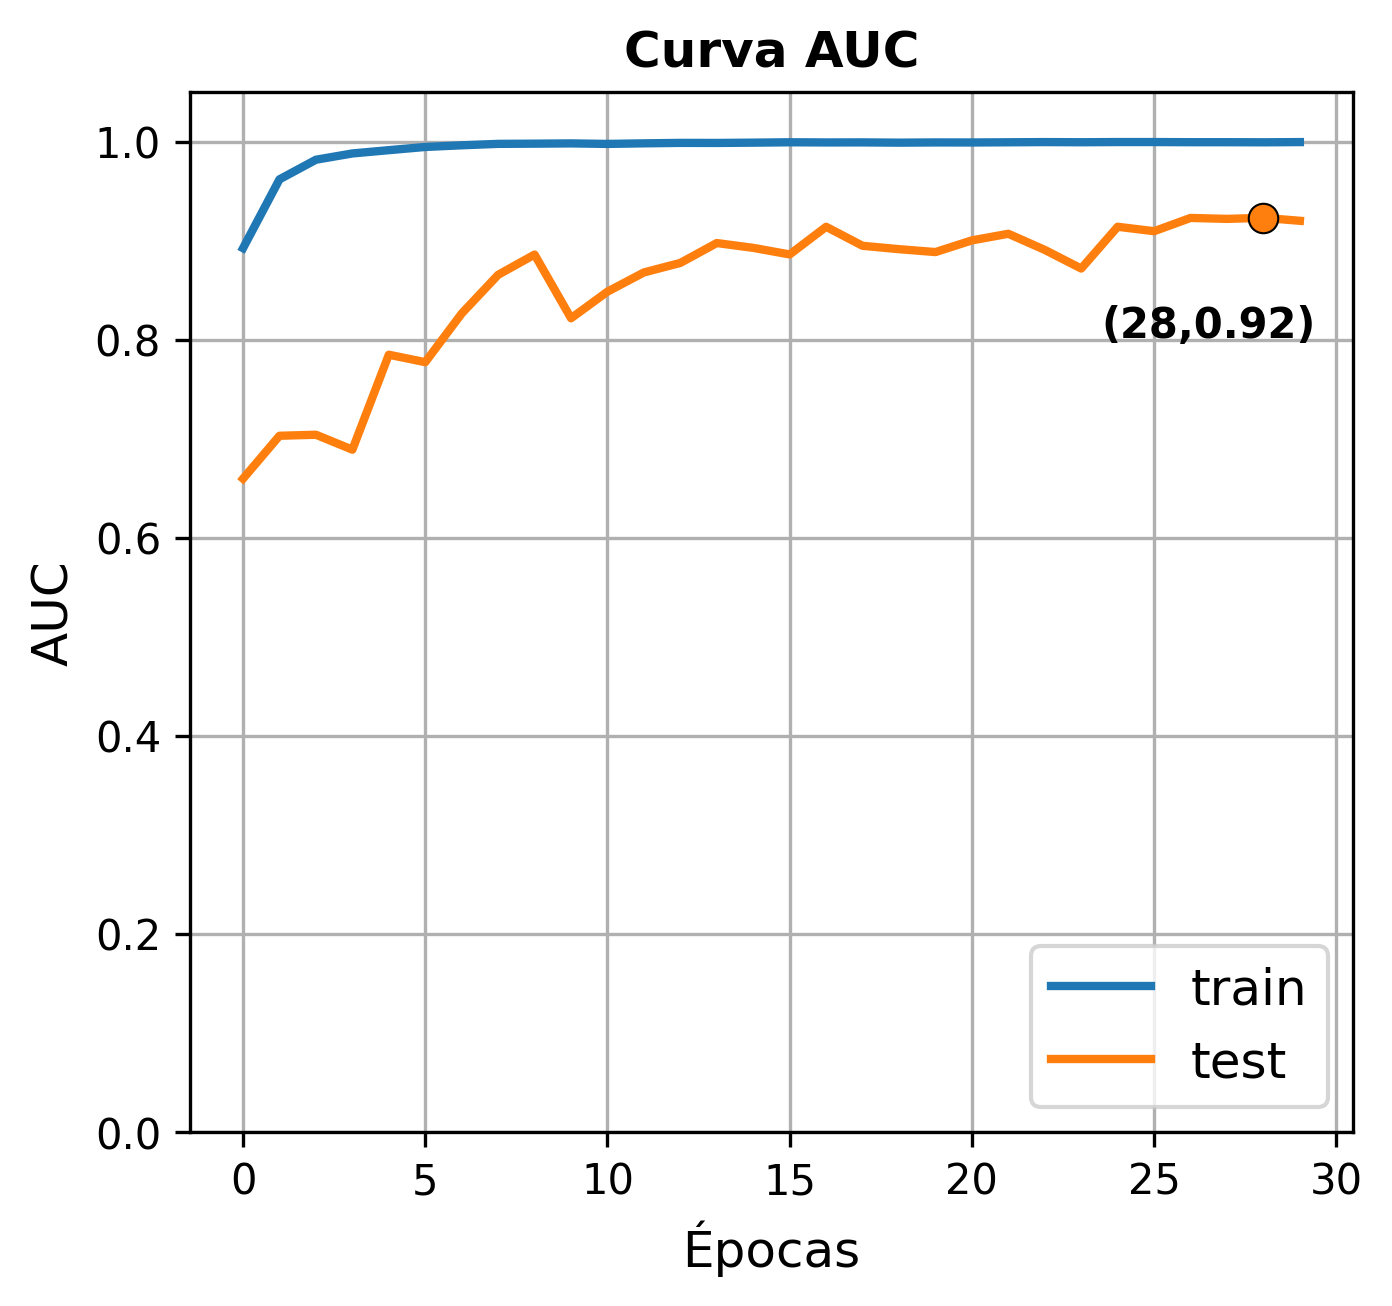

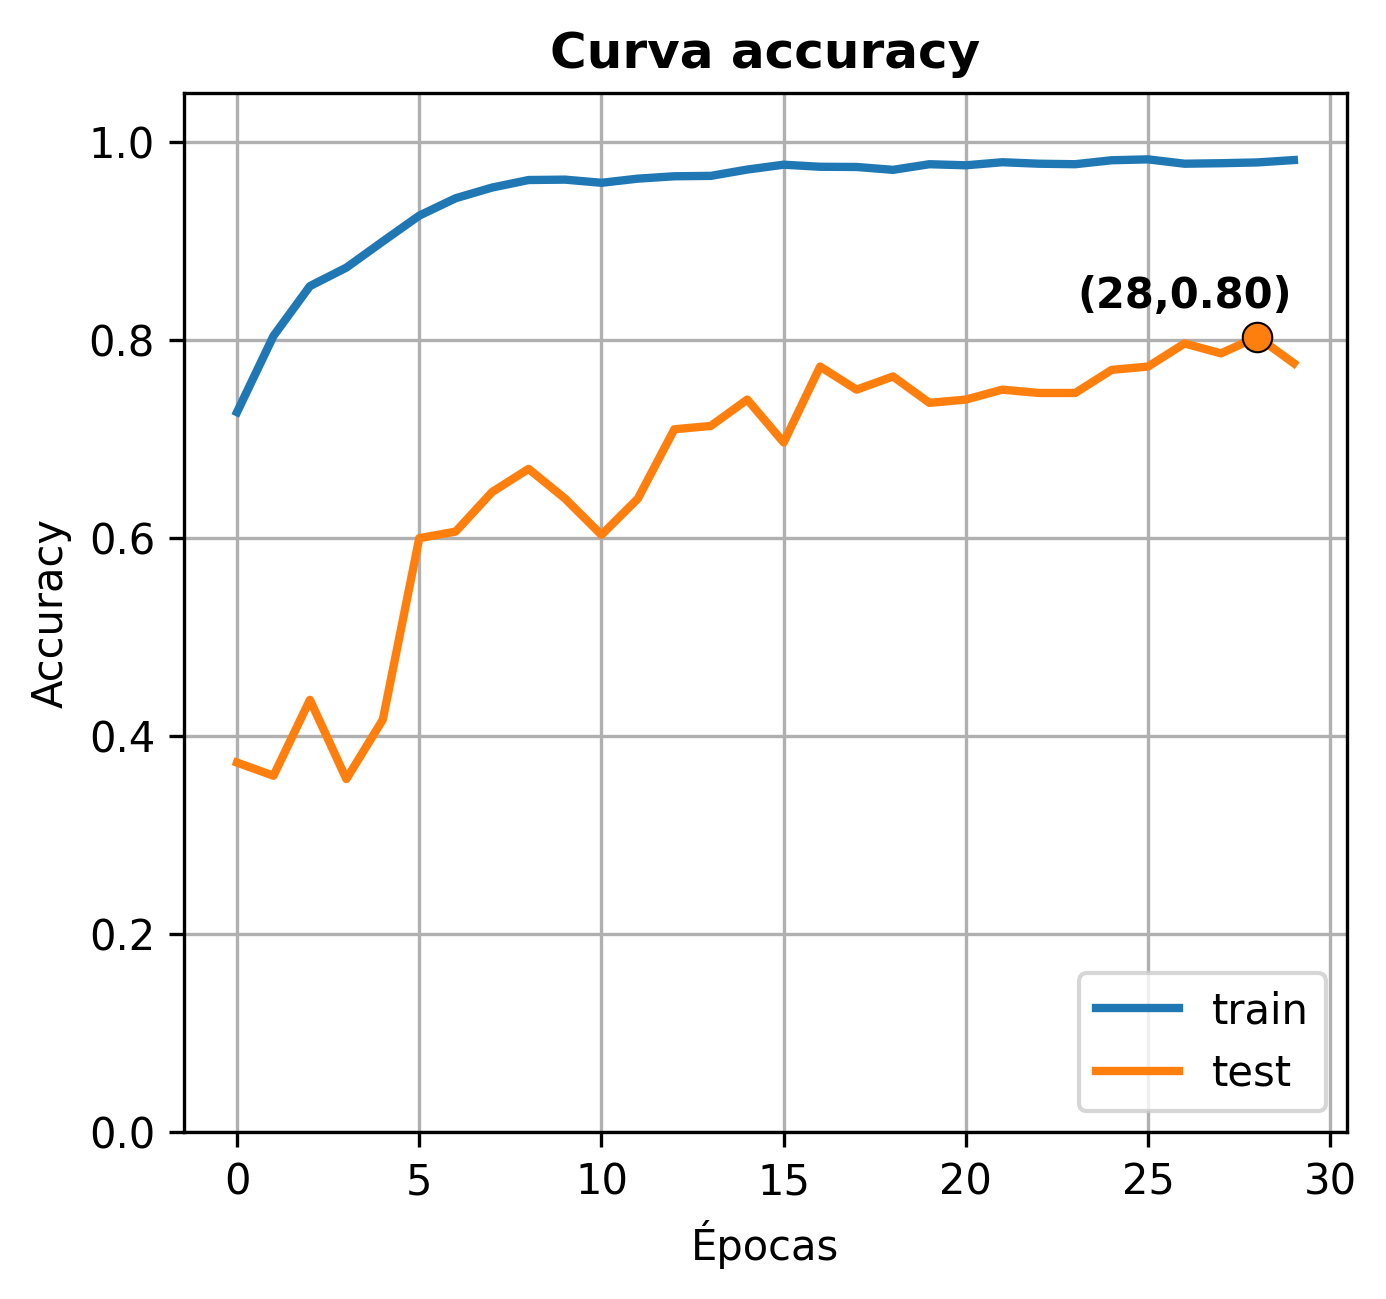

In [3]:
# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['f1'], linewidth=2,)
ax2.plot(datos['val_f1'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('f1-score')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-2, y_max+0.03, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva F1-score',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NA\\subfigura2.png', dpi=300)

# Mostrar la figura
plt.show()



# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['auc'], linewidth=2,)
ax2.plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('AUC',fontsize=12)
ax2.set_xlabel('Épocas',fontsize=12)
ax2.legend(['train', 'test'],loc='lower right',fontsize=12)
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-1.5, y_max-0.13, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva AUC',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NA\\subfigura3.png', dpi=300)

# Mostrar la figura
plt.show()

# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['accuracy'], linewidth=2,)
ax2.plot(datos['val_accuracy'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-2, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva accuracy',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NA\\subfigura1.png', dpi=300)

# Mostrar la figura
plt.show()